Gender Classification

In [ ]:
!unzip /content/gender_classification_dataset.zip

Archive:  /content/gender_classification_dataset.zip
   creating: gender_classification_dataset/
  inflating: __MACOSX/._gender_classification_dataset  
  inflating: gender_classification_dataset/.DS_Store  
  inflating: __MACOSX/gender_classification_dataset/._.DS_Store  
   creating: gender_classification_dataset/male/
  inflating: __MACOSX/gender_classification_dataset/._male  
   creating: gender_classification_dataset/female/
  inflating: __MACOSX/gender_classification_dataset/._female  
  inflating: gender_classification_dataset/meta_data.csv  
  inflating: __MACOSX/gender_classification_dataset/._meta_data.csv  
  inflating: gender_classification_dataset/male/pic302.jpg  
  inflating: __MACOSX/gender_classification_dataset/male/._pic302.jpg  
  inflating: gender_classification_dataset/male/pic464.jpg  
  inflating: __MACOSX/gender_classification_dataset/male/._pic464.jpg  
  inflating: gender_classification_dataset/male/pic470.jpg  
  inflating: __MACOSX/gender_classification_da

Splitting the dataset, creating train and test folders

In [ ]:
import os
import numpy as np
import shutil

rootdir= '/content/gender_classification_dataset' #path of the original folder

classes = ['male', 'female']

for i in classes:
  os.makedirs(rootdir +'/train/' + i)
  os.makedirs(rootdir +'/test/' + i)
  source = rootdir + '/' + i
  allFileNames = os.listdir(source)
  np.random.shuffle(allFileNames)
  test_ratio = 0.2
  train_FileNames, test_FileNames = np.split(np.array(allFileNames),[int(len(allFileNames)* (1 - test_ratio))])
  train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
  test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]
  
  for name in train_FileNames:
    shutil.copy(name, rootdir +'/train/' + i)
  for name in test_FileNames:
    shutil.copy(name, rootdir +'/test/' + i)

In [ ]:
# define and move to dataset directory
datasetdir = '/content/gender_classification_dataset/train'
import os
os.chdir(datasetdir)

# import the needed packages
import matplotlib.pyplot as plt
import matplotlib.image as img
from tensorflow import keras
# shortcut to the ImageDataGenerator class
ImageDataGenerator = keras.preprocessing.image.ImageDataGenerator

Investigating dataset

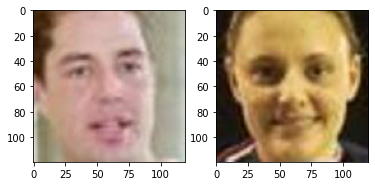

In [ ]:
plt.subplot(1,2,1)
plt.imshow(img.imread('male/pic445.jpg'))
plt.subplot(1,2,2)
plt.imshow(img.imread('female/pic487.jpg'))

Loading the datset with keras

In [ ]:
gen = ImageDataGenerator()

Data Preprocessing, here we are not downsampling the images as its quality is already low

In [ ]:
iterator = gen.flow_from_directory(
    os.getcwd(), 
    target_size=(120,120), 
    classes=('male','female')
)
print(os.getcwd())

Found 640 images belonging to 2 classes.
/content/gender_classification_dataset/train


In [ ]:
# we can guess that the iterator has a next function, 
# because all python iterators have one. 
batch = iterator.next()
len(batch)

2

In [ ]:
print(type(batch[0]))
print(type(batch[1]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Info about dimensions, colour of dataset images

In [ ]:
print(batch[0].shape)
print(batch[0].dtype)
print(batch[0].max())
print(batch[1].shape)
print(batch[1].dtype)

(32, 120, 120, 3)
float32
255.0
(32, 2)
float32


Using label info to print image

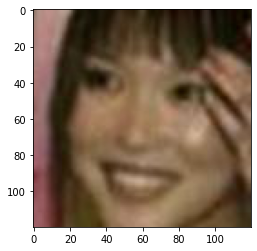

In [ ]:
import numpy as np
# we need to cast the image array to integers 
# before plotting as imshow either takes arrays of integers, 
# or arrays of floats normalized to 1. 
plt.imshow(batch[0][0].astype(np.int))

corresponding label

In [ ]:
batch[1][0]

array([0., 1.], dtype=float32)

label validation

In [ ]:
def plot_images(batch):
    imgs = batch[0]
    labels = batch[1]
    ncols, nrows = 4,8
    fig = plt.figure( figsize=(ncols*3, nrows*3), dpi=90)
    for i, (img,label) in enumerate(zip(imgs,labels)):
      plt.subplot(nrows, ncols, i+1)
      plt.imshow(img.astype(np.int))
      assert(label[0]+label[1]==1.)
      categ = 'male' if label[0]>0.5 else 'female'
      plt.title( '{} {}'.format(str(label), categ))
      plt.axis('off')

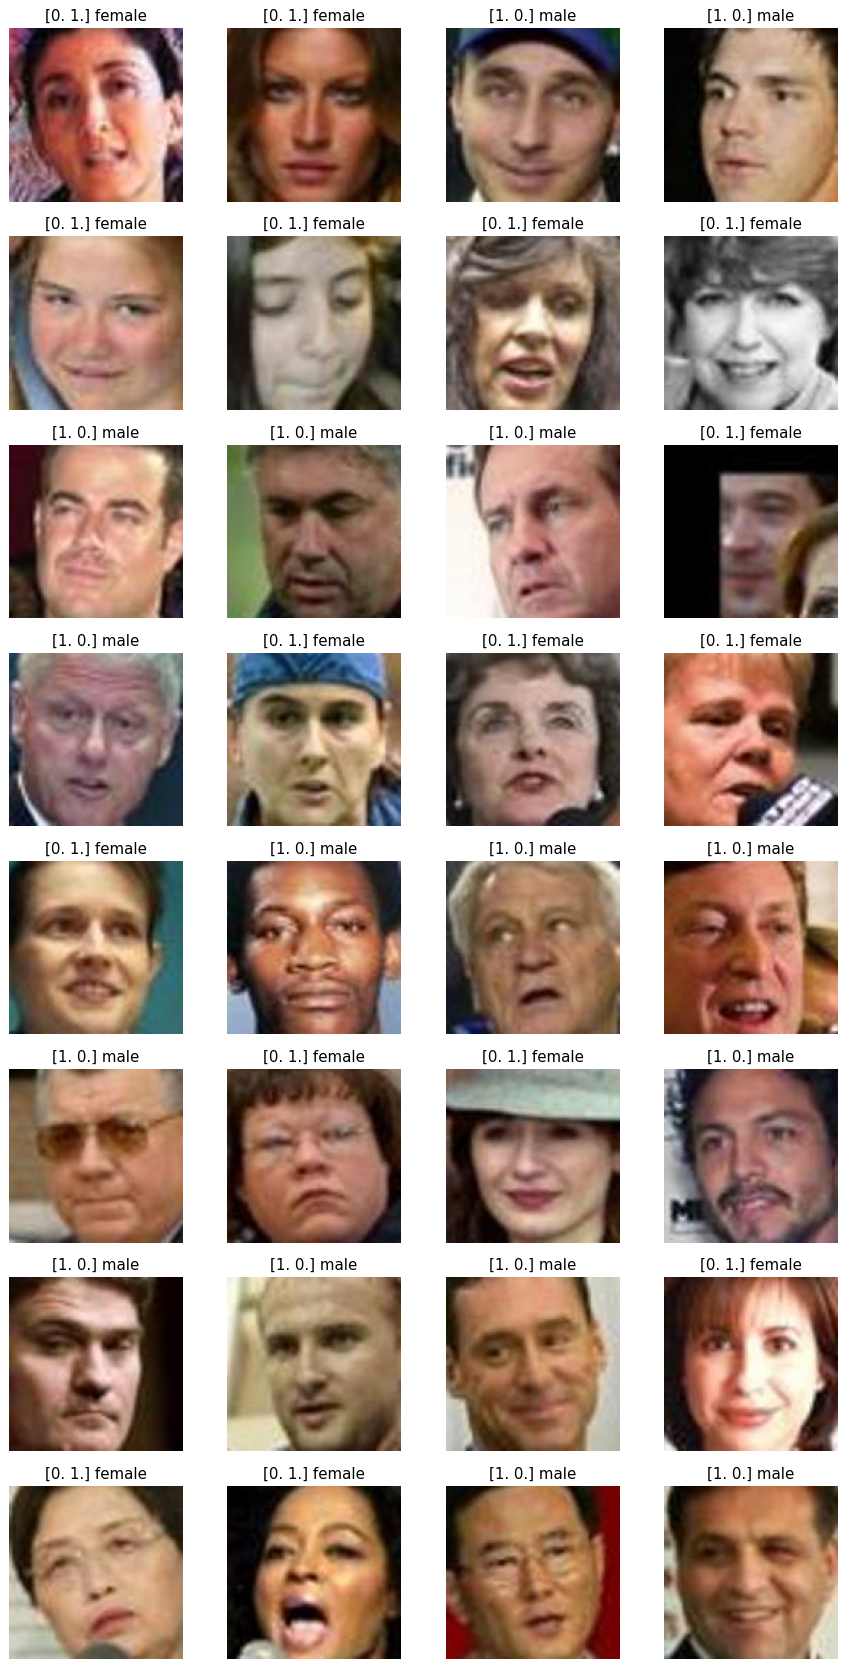

In [ ]:
plot_images(iterator.next())

Split the training and validation dataset with ImageDataGenerator

In [ ]:
imgdatagen = ImageDataGenerator(
    rescale = 1/255., 
    validation_split = 0.2,
)

In [ ]:
accuracy_list = []
optimizer_list = []

Adam

In [ ]:
batch_size = 32
height, width = (120,120)
train_dataset = imgdatagen.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('male','female'),
    batch_size = batch_size,
    subset = 'training'
)

val_dataset = imgdatagen.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('male','female'),
    batch_size = batch_size,
    subset = 'validation'
)

Found 512 images belonging to 2 classes.
Found 128 images belonging to 2 classes.


Feed Forward Fully Connected Neural Network

In [ ]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(50, input_shape=(height,width,3), activation='relu'))
model.add(keras.layers.Dense(24, activation='relu'))
model.add( keras.layers.Flatten() )
model.add( keras.layers.Dropout(0.9) )

model.add( keras.layers.Dense(
    2, activation='softmax',
    )
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 120, 120, 50)      200       
_________________________________________________________________
dense_1 (Dense)              (None, 120, 120, 24)      1224      
_________________________________________________________________
flatten (Flatten)            (None, 345600)            0         
_________________________________________________________________
dropout (Dropout)            (None, 345600)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 691202    
Total params: 692,626
Trainable params: 692,626
Non-trainable params: 0
_________________________________________________________________


Optimizer

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['acc'])

Model Training

In [ ]:
# Saves Keras model after each epoch
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='/content/gender_classification_dataset/img_model_adam.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

In [ ]:
history = model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=20,
    callbacks= checkpointer
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
16/16 [==============================] - 4s 68ms/step - loss: 0.8392 - acc: 0.5029 - val_loss: 0.6197 - val_acc: 0.7188

Epoch 00001: val_loss improved from inf to 0.61966, saving model to /content/gender_classification_dataset/img_model_adam.weights.best.hdf5
Epoch 2/20
16/16 [==============================] - 1s 50ms/step - loss: 0.6289 - acc: 0.6783 - val_loss: 0.5954 - val_acc: 0.6953

Epoch 00002: val_loss improved from 0.61966 to 0.59539, saving model to /content/gender_classification_dataset/img_model_adam.weights.best.hdf5
Epoch 3/20
16/16 [==============================] - 1s 51ms/step - loss: 0.5849 - acc: 0.6930 - val_loss: 0.5503 - val_acc: 0.7266

Epoch 00003: val_loss improved from 0.59539 to 0.55032, saving model to /content/gender_classification_dataset/img_model_adam.weights.best.hdf5
Epoch 4/20
16/16 [==============================] - 1s 49ms/step - loss: 0.5497 - acc: 0.7327 - val_loss: 0.5451 - val_acc: 0.7500

Epoch 00004: val_loss improved from 0.55032 

Function to plot the loss and accuracy for both the training and validation datasets

In [ ]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc, label='training')
    plt.plot(epochs, val_acc,label='validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    plt.legend()
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss, label='training')
    plt.plot(epochs, val_loss, label='validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

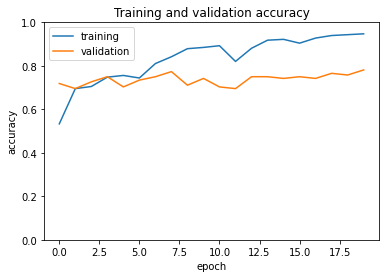

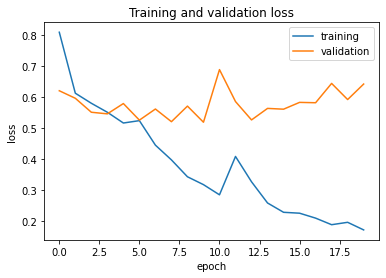

In [ ]:
plot_history(history,(0,1))

Testing our model

In [ ]:
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory('/content/gender_classification_dataset/test',
                                             target_size = (height, width), 
                                             batch_size = 1,
                                             class_mode= None,
                                             classes=classes, 
                                             shuffle=False,
                                             seed=42)


Found 160 images belonging to 2 classes.


In [ ]:
model.load_weights('/content/gender_classification_dataset/img_model_adam.weights.best.hdf5')

predicted_classes = model.predict_classes(testgen)

class_indices = train_dataset.class_indices
print(class_indices)
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


{'male': 0, 'female': 1}


display_results() will compare the images' true labels with the predicted labels.

plot_predictions() will allow us to visualize a sample of the test images, and the labels that the model generates.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, roc_auc_score

def display_results(y_true, y_preds, class_labels):
    tn, fp, fn, tp = confusion_matrix(y_true, y_preds).ravel()
    spf1 = tp / (tp + fp)
    spf2 = tn / (tn+fp)
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
                          
    results.insert(4,'Specificity', [spf1, spf2],True)
    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support', 4: 'Specificity'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    accuracy_list.append(global_acc)
    print("\u001b[1mOverall Categorical Accuracy: {:.2f}%".format(global_acc*100))

    print('\u001b[1mConfusion Matrix')
    print(confusion_matrix(y_true, y_preds))
    auc = roc_auc_score(y_true, y_preds)
    print('\u001b[1mAUC: %.3f' % auc)
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

Plot to visualize a sample of test dataset images

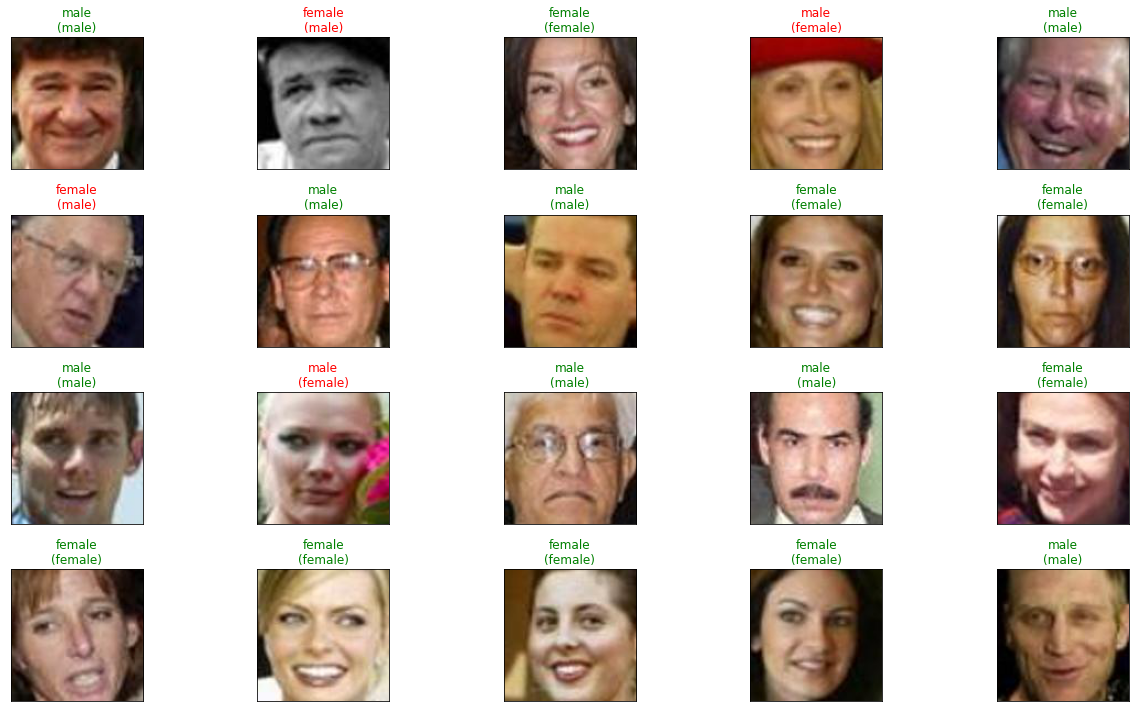

In [ ]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

Accuracy, Precision, Recall/sensitivity, F-score, Support, Specificity, Confusion Matrix, AUC


In [ ]:
display_results(true_classes, predicted_classes, class_indices.values())

Overall Categorical Accuracy: 75.00%
Confusion Matrix
[[62 18]
 [22 58]]
AUC: 0.750


Precision  Recall   F-Score  Support  Specificity
male     0.738095   0.775  0.756098     80.0     0.763158
female   0.763158   0.725  0.743590     80.0     0.775000

In [ ]:
optimizer_list.append('Adam')

Probability of test dataset belonging to {male , female}

female is labeled as 1

{'male': 0, 'female': 1}

In [ ]:
import numpy as np
np.set_printoptions(suppress=True)
prob_male_female = model.predict_proba(testgen, batch_size=1, verbose=1)
print(prob_male_female)

 42/160 [======>.......................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


160/160 [==============================] - 0s 3ms/step
[[0.9980775  0.0019225 ]
 [0.4006831  0.5993169 ]
 [0.15064351 0.8493565 ]
 [0.9961593  0.0038406 ]
 [0.95200455 0.04799543]
 [0.86175054 0.1382495 ]
 [0.9988551  0.00114485]
 [0.7643245  0.23567548]
 [0.98786086 0.01213918]
 [0.6474529  0.3525471 ]
 [0.05382697 0.946173  ]
 [0.17822903 0.8217709 ]
 [0.99861896 0.001381  ]
 [0.9304063  0.06959379]
 [0.5976888  0.40231115]
 [0.9252265  0.07477344]
 [0.5226086  0.47739142]
 [0.99997187 0.00002809]
 [0.98857063 0.01142932]
 [0.99322516 0.00677483]
 [0.99648607 0.00351388]
 [0.21488792 0.785112  ]
 [0.9755104  0.02448957]
 [0.31264156 0.6873585 ]
 [0.8743964  0.12560362]
 [0.610846   0.38915402]
 [0.2521003  0.7478997 ]
 [0.9927105  0.00728954]
 [0.86502147 0.1349785 ]
 [0.78655136 0.21344861]
 [0.39302823 0.60697174]
 [0.99967635 0.00032364]
 [0.9846603  0.01533961]
 [0.9979563  0.00204368]
 [0.996962   0.00303795]
 [0.96722454 0.03277542]
 [0.8012481  0.19875199]
 [0.98355585 0.01644

Probability of each test dataset image falling into positive class

female is labeled as 1

{'male': 0, 'female': 1}

image path---------> prob(image belongs to female dataset)

In [ ]:
print("%-70s %-10s" % ("Image_Path", "Probability( Female)"))
for i in range(len(testgen.filepaths)):
  print("%-70s %-10.4f" % (testgen.filepaths[i], prob_male_female[i][1]))

Image_Path                                                             Probability( Female)
/content/gender_classification_dataset/test/male/pic226.jpg            0.0019    
/content/gender_classification_dataset/test/male/pic230.jpg            0.5993    
/content/gender_classification_dataset/test/male/pic256.jpg            0.8494    
/content/gender_classification_dataset/test/male/pic258.jpg            0.0038    
/content/gender_classification_dataset/test/male/pic283.jpg            0.0480    
/content/gender_classification_dataset/test/male/pic285.jpg            0.1382    
/content/gender_classification_dataset/test/male/pic297.jpg            0.0011    
/content/gender_classification_dataset/test/male/pic300.jpg            0.2357    
/content/gender_classification_dataset/test/male/pic301.jpg            0.0121    
/content/gender_classification_dataset/test/male/pic304.jpg            0.3525    
/content/gender_classification_dataset/test/male/pic314.jpg            0.9462    
/conte

SGD batch size = maximum

Found 512 images belonging to 2 classes.
Found 128 images belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 120, 120, 50)      200       
_________________________________________________________________
dense_4 (Dense)              (None, 120, 120, 24)      1224      
_________________________________________________________________
flatten_1 (Flatten)          (None, 345600)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 345600)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 691202    
Total params: 692,626
Trainable params: 692,626
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.7141 - acc: 0.5176 - val_loss: 0.6941 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 0.69414, saving model to /content/gender_classification_dataset/img_model_bsmax.weights.best.hdf5
Epoch 2/20
1/1 [==============================] - 1s 875ms/step - loss: 0.7150 - acc: 0.5234 - val_loss: 0.7040 - val_acc: 0.5000

Epoch 00002: val_loss did not improve from 0.69414
Epoch 3/20
1/1 [==============================] - 1s 861ms/step - loss: 0.7199 - acc: 0.5273 - val_loss: 0.7177 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 0.69414
Epoch 4/20
1/1 [==============================] - 1s 880ms/step - loss: 0.7348 - acc: 0.5234 - val_loss: 0.7592 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 0.69414
Epoch 5/20
1/1 [==============================] - 1s 776ms/step - loss: 0.7643 - acc: 0.5117 - val_loss: 0.7572 - val_acc: 0.5000

Epoch 00005: val_loss did not improve from 0.69414
Epo

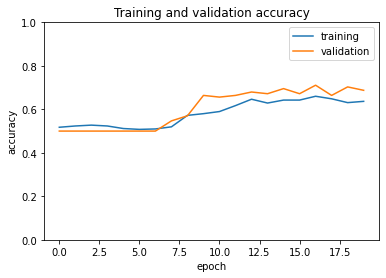

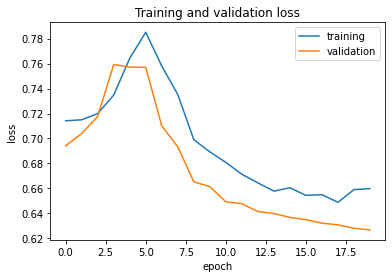

Found 160 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


{'male': 0, 'female': 1}
Overall Categorical Accuracy: 62.50%
Confusion Matrix
[[54 26]
 [34 46]]
AUC: 0.625


Precision  Recall   F-Score  Support  Specificity
male     0.613636   0.675  0.642857     80.0     0.638889
female   0.638889   0.575  0.605263     80.0     0.675000

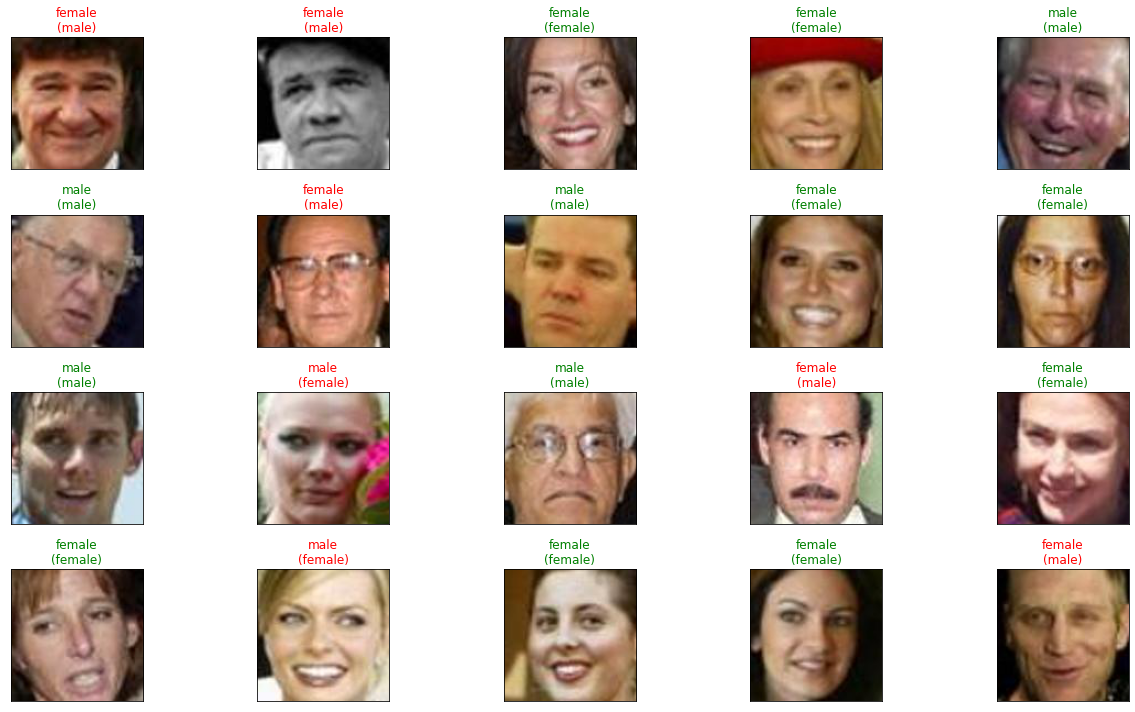

In [ ]:
height, width = (120,120)
train_dataset = imgdatagen.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('male','female'),
    batch_size = 512,
    subset = 'training'
)

val_dataset = imgdatagen.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('male','female'),
    batch_size = 128,
    subset = 'validation'
)

#Feed Forward Fully Connected Neural Network

model = keras.models.Sequential()

model.add(keras.layers.Dense(50, input_shape=(height,width,3), activation='relu'))
model.add(keras.layers.Dense(24, activation='relu'))
model.add( keras.layers.Flatten() )
model.add( keras.layers.Dropout(0.9) )

model.add( keras.layers.Dense(
    2, activation='softmax',
    )
)

model.summary()

#Optimizer
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(lr = 0.01),
              metrics=['acc'])
#Model Training
# Saves Keras model after each epoch
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='/content/gender_classification_dataset/img_model_bsmax.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)
history = model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=20,
    callbacks= checkpointer
)


plot_history(history,(0,1))

#Testing our model
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory('/content/gender_classification_dataset/test',
                                             target_size = (height, width), 
                                             batch_size = 1,
                                             class_mode= None,
                                             classes=classes, 
                                             shuffle=False,
                                             seed=42)
model.load_weights('/content/gender_classification_dataset/img_model_bsmax.weights.best.hdf5')

predicted_classes = model.predict_classes(testgen)

class_indices = train_dataset.class_indices
print(class_indices)
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

#Plot to visualize a sample of test dataset images        
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

#Accuracy, Precision, Recall/sensitivity, F-score, Support, Specificity, Confusion Matrix, AUC
display_results(true_classes, predicted_classes, class_indices.values())


In [ ]:
optimizer_list.append('SGD(BS=N)')

In [ ]:
# Probability of test dataset belonging to {male , female}

# female is labeled as 1

# {'male': 0, 'female': 1}

import numpy as np
np.set_printoptions(suppress=True)
prob_male_female = model.predict_proba(testgen, batch_size=1, verbose=1)
print(prob_male_female)

# Probability of each test dataset image falling into positive class

# female is labeled as 1

# {'male': 0, 'female': 1}

# image path---------> prob(image belongs to female dataset)

print("%-70s %-10s" % ("Image_Path", "Probability( Female)"))
for i in range(len(testgen.filepaths)):
  print("%-70s %-10.4f" % (testgen.filepaths[i], prob_male_female[i][1]))

 30/160 [====>.........................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


160/160 [==============================] - 1s 3ms/step
[[0.7454318  0.25456822]
 [0.5237448  0.47625515]
 [0.6698574  0.33014265]
 [0.6690545  0.33094546]
 [0.6515102  0.34848976]
 [0.46105996 0.53894   ]
 [0.5487626  0.45123735]
 [0.83719677 0.16280322]
 [0.6746948  0.32530528]
 [0.76708966 0.23291035]
 [0.24106486 0.75893515]
 [0.3839368  0.6160632 ]
 [0.66632    0.33368   ]
 [0.73032826 0.26967177]
 [0.45116103 0.548839  ]
 [0.5954434  0.40455663]
 [0.6513997  0.34860036]
 [0.7923283  0.20767164]
 [0.5141902  0.48580977]
 [0.5351077  0.46489236]
 [0.5619827  0.43801728]
 [0.47685075 0.52314925]
 [0.78510505 0.21489492]
 [0.4203981  0.5796019 ]
 [0.48362443 0.5163756 ]
 [0.37610593 0.6238941 ]
 [0.5707764  0.42922357]
 [0.7123379  0.28766215]
 [0.69524413 0.30475584]
 [0.6285955  0.37140447]
 [0.2817809  0.7182191 ]
 [0.60057104 0.39942893]
 [0.5762384  0.42376164]
 [0.75938356 0.24061649]
 [0.695166   0.30483407]
 [0.448906   0.55109406]
 [0.36785236 0.6321476 ]
 [0.41976467 0.58023

SGD batch size = 32

Found 512 images belonging to 2 classes.
Found 128 images belonging to 2 classes.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 120, 120, 50)      200       
_________________________________________________________________
dense_7 (Dense)              (None, 120, 120, 24)      1224      
_________________________________________________________________
flatten_2 (Flatten)          (None, 345600)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 345600)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 691202    
Total params: 692,626
Trainable params: 692,626
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


16/16 [==============================] - 2s 68ms/step - loss: 1.3061 - acc: 0.4967 - val_loss: 0.6338 - val_acc: 0.6406

Epoch 00001: val_loss improved from inf to 0.63376, saving model to /content/gender_classification_dataset/img_model_bs32.weights.best.hdf5
Epoch 2/20
16/16 [==============================] - 1s 56ms/step - loss: 0.6486 - acc: 0.6664 - val_loss: 0.6158 - val_acc: 0.6953

Epoch 00002: val_loss improved from 0.63376 to 0.61575, saving model to /content/gender_classification_dataset/img_model_bs32.weights.best.hdf5
Epoch 3/20
16/16 [==============================] - 1s 56ms/step - loss: 0.6307 - acc: 0.6921 - val_loss: 0.5983 - val_acc: 0.7266

Epoch 00003: val_loss improved from 0.61575 to 0.59831, saving model to /content/gender_classification_dataset/img_model_bs32.weights.best.hdf5
Epoch 4/20
16/16 [==============================] - 1s 54ms/step - loss: 0.6262 - acc: 0.6967 - val_loss: 0.6350 - val_acc: 0.6641

Epoch 00004: val_loss did not improve from 0.59831
Epoc

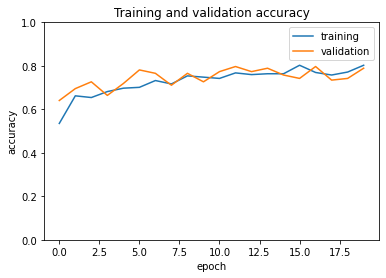

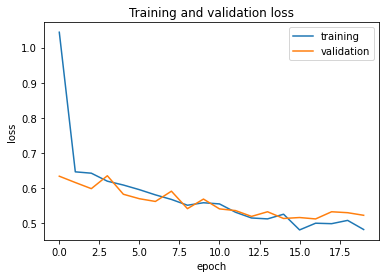

Found 160 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


{'male': 0, 'female': 1}
Overall Categorical Accuracy: 75.62%
Confusion Matrix
[[64 16]
 [23 57]]
AUC: 0.756


Precision  Recall   F-Score  Support  Specificity
male     0.735632  0.8000  0.766467     80.0     0.780822
female   0.780822  0.7125  0.745098     80.0     0.800000

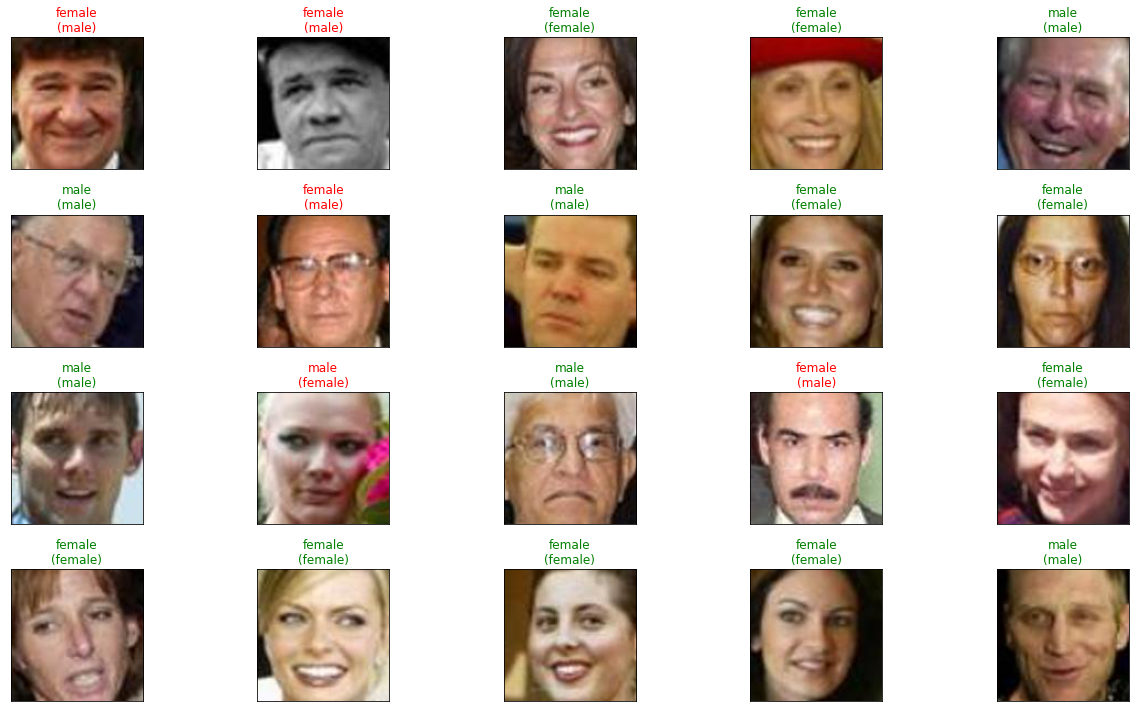

In [ ]:
batch_size = 32
height, width = (120,120)
train_dataset = imgdatagen.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('male','female'),
    batch_size = batch_size,
    subset = 'training'
)

val_dataset = imgdatagen.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('male','female'),
    batch_size = batch_size,
    subset = 'validation'
)

#Feed Forward Fully Connected Neural Network

model = keras.models.Sequential()

model.add(keras.layers.Dense(50, input_shape=(height,width,3), activation='relu'))
model.add(keras.layers.Dense(24, activation='relu'))
model.add( keras.layers.Flatten() )
model.add( keras.layers.Dropout(0.9) )

model.add( keras.layers.Dense(
    2, activation='softmax',
    )
)

model.summary()

#Optimizer
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(lr = 0.01),
              metrics=['acc'])
#Model Training
# Saves Keras model after each epoch
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='/content/gender_classification_dataset/img_model_bs32.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)
history = model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=20,
    callbacks= checkpointer
)


plot_history(history,(0,1))

#Testing our model
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory('/content/gender_classification_dataset/test',
                                             target_size = (height, width), 
                                             batch_size = 1,
                                             class_mode= None,
                                             classes=classes, 
                                             shuffle=False,
                                             seed=42)
model.load_weights('/content/gender_classification_dataset/img_model_bs32.weights.best.hdf5')

predicted_classes = model.predict_classes(testgen)

class_indices = train_dataset.class_indices
print(class_indices)
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

#Plot to visualize a sample of test dataset images        
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

#Accuracy, Precision, Recall/sensitivity, F-score, Support, Specificity, Confusion Matrix, AUC
display_results(true_classes, predicted_classes, class_indices.values())


In [ ]:
optimizer_list.append('SGD(BS=32)')

In [ ]:
# Probability of test dataset belonging to {male , female}

# female is labeled as 1

# {'male': 0, 'female': 1}

import numpy as np
np.set_printoptions(suppress=True)
prob_male_female = model.predict_proba(testgen, batch_size=1, verbose=1)
print(prob_male_female)

# Probability of each test dataset image falling into positive class

# female is labeled as 1

# {'male': 0, 'female': 1}

# image path---------> prob(image belongs to female dataset)

print("%-70s %-10s" % ("Image_Path", "Probability( Female)"))
for i in range(len(testgen.filepaths)):
  print("%-70s %-10.4f" % (testgen.filepaths[i], prob_male_female[i][1]))

 28/160 [====>.........................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


160/160 [==============================] - 1s 3ms/step
[[0.9887905  0.01120955]
 [0.63605773 0.36394224]
 [0.86168796 0.1383121 ]
 [0.9669535  0.03304654]
 [0.93974257 0.06025745]
 [0.5296717  0.47032827]
 [0.82571924 0.17428075]
 [0.99012953 0.00987045]
 [0.9432756  0.05672449]
 [0.8887423  0.11125764]
 [0.05444309 0.9455569 ]
 [0.18075632 0.81924367]
 [0.95845586 0.0415441 ]
 [0.7895016  0.21049836]
 [0.49572417 0.5042758 ]
 [0.8195424  0.18045759]
 [0.90862364 0.09137636]
 [0.9943382  0.00566177]
 [0.6138327  0.38616735]
 [0.8823328  0.11766718]
 [0.8830138  0.1169862 ]
 [0.4237008  0.57629925]
 [0.9845806  0.01541935]
 [0.64871645 0.35128352]
 [0.601774   0.39822602]
 [0.5737255  0.42627448]
 [0.55111027 0.4488897 ]
 [0.8884864  0.11151363]
 [0.8843374  0.1156626 ]
 [0.9085399  0.09146009]
 [0.29937032 0.70062965]
 [0.9860545  0.01394553]
 [0.8948203  0.10517975]
 [0.9890448  0.01095519]
 [0.9757036  0.02429632]
 [0.8007862  0.1992138 ]
 [0.3925632  0.60743684]
 [0.8132879  0.18671

SGD batch size = 1

Found 512 images belonging to 2 classes.
Found 128 images belonging to 2 classes.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 120, 120, 50)      200       
_________________________________________________________________
dense_10 (Dense)             (None, 120, 120, 24)      1224      
_________________________________________________________________
flatten_3 (Flatten)          (None, 345600)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 345600)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 691202    
Total params: 692,626
Trainable params: 692,626
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


512/512 [==============================] - 4s 6ms/step - loss: 0.7247 - acc: 0.5049 - val_loss: 0.6929 - val_acc: 0.4922

Epoch 00001: val_loss improved from inf to 0.69294, saving model to /content/gender_classification_dataset/img_model_bs1.weights.best.hdf5
Epoch 2/20
512/512 [==============================] - 3s 6ms/step - loss: 0.6953 - acc: 0.5688 - val_loss: 0.6831 - val_acc: 0.6797

Epoch 00002: val_loss improved from 0.69294 to 0.68314, saving model to /content/gender_classification_dataset/img_model_bs1.weights.best.hdf5
Epoch 3/20
512/512 [==============================] - 3s 6ms/step - loss: 0.6956 - acc: 0.5483 - val_loss: 0.6806 - val_acc: 0.5078

Epoch 00003: val_loss improved from 0.68314 to 0.68063, saving model to /content/gender_classification_dataset/img_model_bs1.weights.best.hdf5
Epoch 4/20
512/512 [==============================] - 3s 6ms/step - loss: 0.7001 - acc: 0.6408 - val_loss: 0.6329 - val_acc: 0.6094

Epoch 00004: val_loss improved from 0.68063 to 0.63291

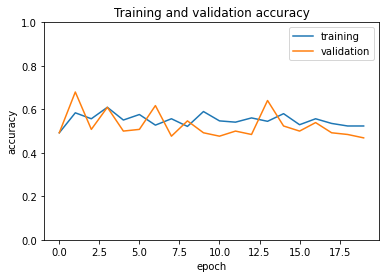

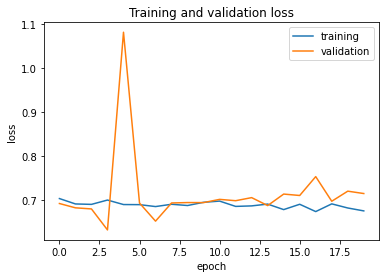

Found 160 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


{'male': 0, 'female': 1}
Overall Categorical Accuracy: 57.50%
Confusion Matrix
[[29 51]
 [17 63]]
AUC: 0.575


Precision  Recall   F-Score  Support  Specificity
female   0.552632  0.7875  0.649485     80.0     0.362500
male     0.630435  0.3625  0.460317     80.0     0.552632

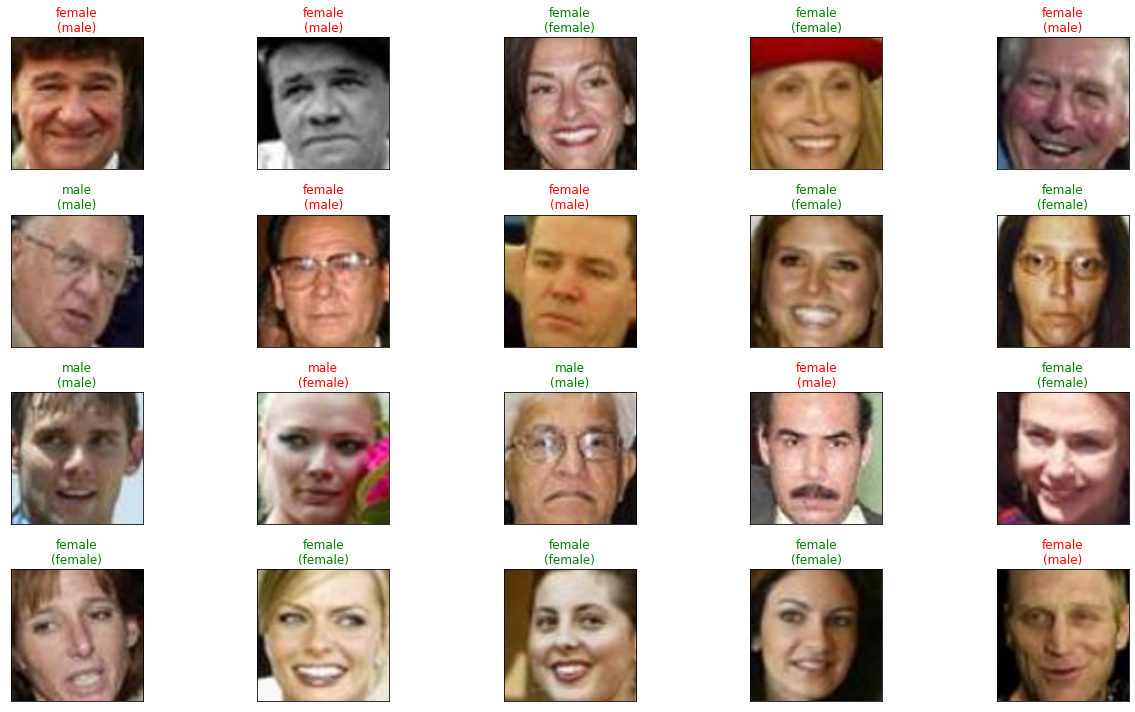

In [ ]:
batch_size = 1
height, width = (120,120)
train_dataset = imgdatagen.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('male','female'),
    batch_size = batch_size,
    subset = 'training'
)

val_dataset = imgdatagen.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('male','female'),
    batch_size = batch_size,
    subset = 'validation'
)

#Feed Forward Fully Connected Neural Network

model = keras.models.Sequential()

model.add(keras.layers.Dense(50, input_shape=(height,width,3), activation='relu'))
model.add(keras.layers.Dense(24, activation='relu'))
model.add( keras.layers.Flatten() )
model.add( keras.layers.Dropout(0.9) )

model.add( keras.layers.Dense(
    2, activation='softmax',
    )
)

model.summary()

#Optimizer
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(lr = 0.01),
              metrics=['acc'])
#Model Training
# Saves Keras model after each epoch
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='/content/gender_classification_dataset/img_model_bs1.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)
history = model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=20,
    callbacks= checkpointer
)


plot_history(history,(0,1))

#Testing our model
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory('/content/gender_classification_dataset/test',
                                             target_size = (height, width), 
                                             batch_size = 1,
                                             class_mode= None,
                                             classes=classes, 
                                             shuffle=False,
                                             seed=42)
model.load_weights('/content/gender_classification_dataset/img_model_bs1.weights.best.hdf5')

predicted_classes = model.predict_classes(testgen)

class_indices = train_dataset.class_indices
print(class_indices)
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

#Plot to visualize a sample of test dataset images        
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

#Accuracy, Precision, Recall/sensitivity, F-score, Support, Specificity, Confusion Matrix, AUC
display_results(true_classes, predicted_classes, class_indices.values())


In [ ]:
optimizer_list.append('SGD(BS=1)')

In [ ]:

# Probability of test dataset belonging to {male , female}

# female is labeled as 1

# {'male': 0, 'female': 1}

import numpy as np
np.set_printoptions(suppress=True)
prob_male_female = model.predict_proba(testgen, batch_size=1, verbose=1)
print(prob_male_female)

# Probability of each test dataset image falling into positive class

# female is labeled as 1

# {'male': 0, 'female': 1}

# image path---------> prob(image belongs to female dataset)

print("%-70s %-10s" % ("Image_Path", "Probability( Female)"))
for i in range(len(testgen.filepaths)):
  print("%-70s %-10.4f" % (testgen.filepaths[i], prob_male_female[i][1]))

 29/160 [====>.........................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


160/160 [==============================] - 0s 3ms/step
[[0.6184148  0.3815852 ]
 [0.26216605 0.7378339 ]
 [0.28128916 0.71871084]
 [0.50839615 0.4916038 ]
 [0.58061    0.41939002]
 [0.49088585 0.5091141 ]
 [0.29429007 0.70570993]
 [0.34173328 0.6582668 ]
 [0.4889579  0.51104206]
 [0.5451978  0.45480224]
 [0.35711464 0.6428853 ]
 [0.24475645 0.75524354]
 [0.5752634  0.42473662]
 [0.64871114 0.3512889 ]
 [0.3065346  0.6934654 ]
 [0.51795727 0.4820427 ]
 [0.54023993 0.4597601 ]
 [0.89025295 0.10974699]
 [0.50165665 0.49834335]
 [0.27242798 0.727572  ]
 [0.44610587 0.5538941 ]
 [0.26846737 0.7315327 ]
 [0.53324664 0.4667534 ]
 [0.42211488 0.5778851 ]
 [0.28397486 0.7160252 ]
 [0.29314974 0.70685023]
 [0.3737653  0.6262347 ]
 [0.5587686  0.4412314 ]
 [0.6082848  0.39171526]
 [0.4646565  0.5353435 ]
 [0.15532434 0.84467566]
 [0.5769167  0.42308325]
 [0.5453238  0.45467624]
 [0.58307344 0.41692656]
 [0.54148215 0.45851788]
 [0.3328684  0.6671316 ]
 [0.28377807 0.7162219 ]
 [0.13809215 0.86190

RMSprop

Found 512 images belonging to 2 classes.
Found 128 images belonging to 2 classes.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 120, 120, 50)      200       
_________________________________________________________________
dense_13 (Dense)             (None, 120, 120, 24)      1224      
_________________________________________________________________
flatten_4 (Flatten)          (None, 345600)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 345600)            0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 691202    
Total params: 692,626
Trainable params: 692,626
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


16/16 [==============================] - 2s 68ms/step - loss: 2.7842 - acc: 0.5010 - val_loss: 0.5792 - val_acc: 0.7188

Epoch 00001: val_loss improved from inf to 0.57920, saving model to /content/gender_classification_dataset/img_model_rmsprop.weights.best.hdf5
Epoch 2/20
16/16 [==============================] - 1s 55ms/step - loss: 0.6568 - acc: 0.6823 - val_loss: 0.5855 - val_acc: 0.7188

Epoch 00002: val_loss did not improve from 0.57920
Epoch 3/20
16/16 [==============================] - 1s 54ms/step - loss: 0.6241 - acc: 0.6533 - val_loss: 0.5909 - val_acc: 0.6797

Epoch 00003: val_loss did not improve from 0.57920
Epoch 4/20
16/16 [==============================] - 1s 57ms/step - loss: 0.5711 - acc: 0.7213 - val_loss: 0.5487 - val_acc: 0.7734

Epoch 00004: val_loss improved from 0.57920 to 0.54869, saving model to /content/gender_classification_dataset/img_model_rmsprop.weights.best.hdf5
Epoch 5/20
16/16 [==============================] - 1s 53ms/step - loss: 0.5751 - acc: 0.73

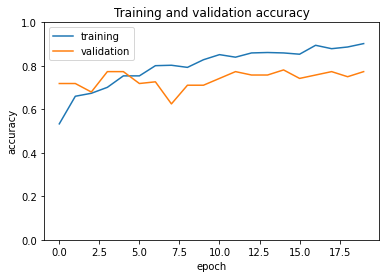

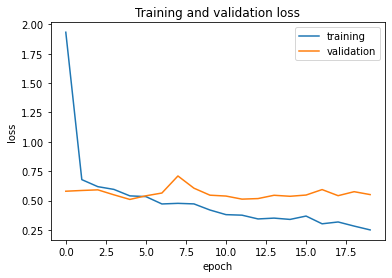

Found 160 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


{'male': 0, 'female': 1}
Overall Categorical Accuracy: 67.50%
Confusion Matrix
[[48 32]
 [20 60]]
AUC: 0.675


Precision  Recall   F-Score  Support  Specificity
female   0.652174    0.75  0.697674     80.0     0.600000
male     0.705882    0.60  0.648649     80.0     0.652174

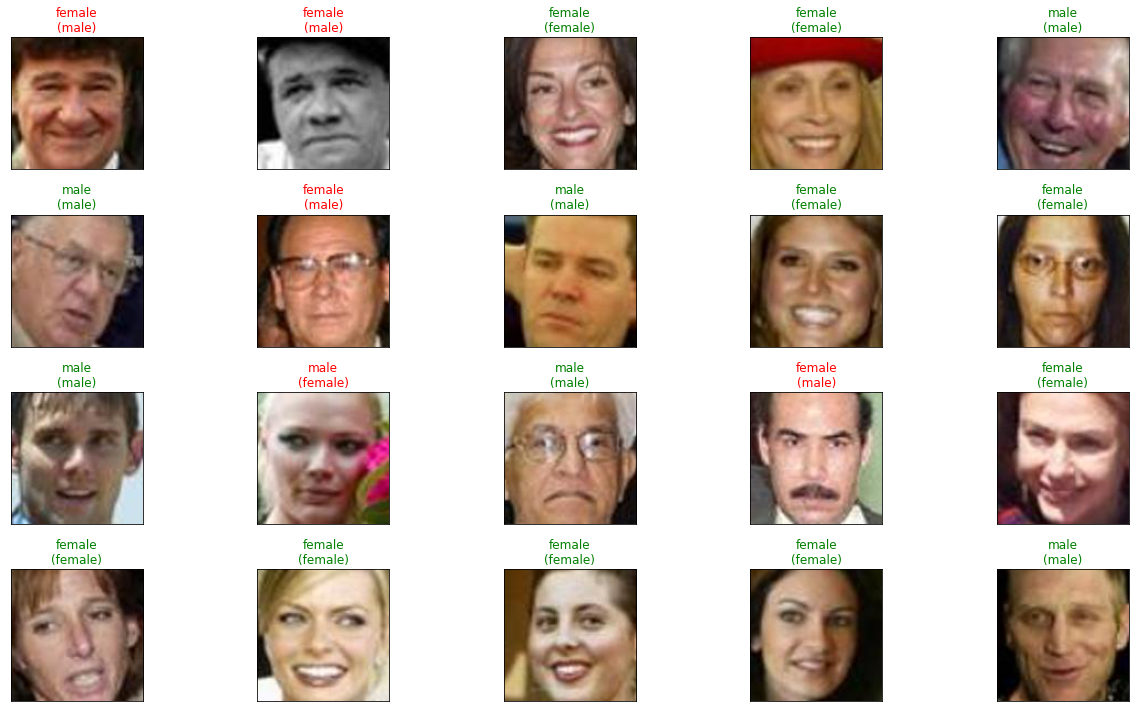

In [ ]:
batch_size = 32
height, width = (120,120)
train_dataset = imgdatagen.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('male','female'),
    batch_size = batch_size,
    subset = 'training'
)

val_dataset = imgdatagen.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('male','female'),
    batch_size = batch_size,
    subset = 'validation'
)

#Feed Forward Fully Connected Neural Network

model = keras.models.Sequential()

model.add(keras.layers.Dense(50, input_shape=(height,width,3), activation='relu'))
model.add(keras.layers.Dense(24, activation='relu'))
model.add( keras.layers.Flatten() )
model.add( keras.layers.Dropout(0.9) )

model.add( keras.layers.Dense(
    2, activation='softmax',
    )
)

model.summary()

#Optimizer
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr = 0.001),
              metrics=['acc'])
#Model Training
# Saves Keras model after each epoch
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='/content/gender_classification_dataset/img_model_rmsprop.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)
history = model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=20,
    callbacks= checkpointer
)


plot_history(history,(0,1))

#Testing our model
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory('/content/gender_classification_dataset/test',
                                             target_size = (height, width), 
                                             batch_size = 1,
                                             class_mode= None,
                                             classes=classes, 
                                             shuffle=False,
                                             seed=42)
model.load_weights('/content/gender_classification_dataset/img_model_rmsprop.weights.best.hdf5')

predicted_classes = model.predict_classes(testgen)

class_indices = train_dataset.class_indices
print(class_indices)
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

#Plot to visualize a sample of test dataset images        
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

#Accuracy, Precision, Recall/sensitivity, F-score, Support, Specificity, Confusion Matrix, AUC
display_results(true_classes, predicted_classes, class_indices.values())


In [ ]:
optimizer_list.append('RMSprop')

In [ ]:

# Probability of test dataset belonging to {male , female}

# female is labeled as 1

# {'male': 0, 'female': 1}

import numpy as np
np.set_printoptions(suppress=True)
prob_male_female = model.predict_proba(testgen, batch_size=1, verbose=1)
print(prob_male_female)

# Probability of each test dataset image falling into positive class

# female is labeled as 1

# {'male': 0, 'female': 1}

# image path---------> prob(image belongs to female dataset)

print("%-70s %-10s" % ("Image_Path", "Probability( Female)"))
for i in range(len(testgen.filepaths)):
  print("%-70s %-10.4f" % (testgen.filepaths[i], prob_male_female[i][1]))

 32/160 [=====>........................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


160/160 [==============================] - 1s 3ms/step
[[0.99466264 0.00533728]
 [0.4820015  0.5179985 ]
 [0.34779888 0.6522011 ]
 [0.97823733 0.02176268]
 [0.93493104 0.06506896]
 [0.24958895 0.75041103]
 [0.90311694 0.0968831 ]
 [0.99395293 0.00604708]
 [0.9672403  0.03275974]
 [0.48423415 0.51576585]
 [0.00168593 0.998314  ]
 [0.00969555 0.9903045 ]
 [0.98080486 0.01919513]
 [0.917586   0.08241402]
 [0.24616979 0.7538302 ]
 [0.5385855  0.4614145 ]
 [0.25179735 0.7482027 ]
 [0.9970661  0.00293395]
 [0.52037555 0.47962448]
 [0.8221637  0.17783628]
 [0.8979121  0.10208792]
 [0.19928217 0.80071783]
 [0.9669311  0.03306887]
 [0.19539167 0.8046083 ]
 [0.4478025  0.55219746]
 [0.35261014 0.6473898 ]
 [0.04945906 0.950541  ]
 [0.88653326 0.11346672]
 [0.7785423  0.22145775]
 [0.8779707  0.12202925]
 [0.00115787 0.9988422 ]
 [0.99868745 0.00131254]
 [0.6870466  0.31295344]
 [0.99508923 0.00491077]
 [0.977879   0.02212104]
 [0.5832387  0.41676125]
 [0.38243166 0.6175683 ]
 [0.67172515 0.32827

Adagrad

Found 512 images belonging to 2 classes.
Found 128 images belonging to 2 classes.
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 120, 120, 50)      200       
_________________________________________________________________
dense_16 (Dense)             (None, 120, 120, 24)      1224      
_________________________________________________________________
flatten_5 (Flatten)          (None, 345600)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 345600)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 691202    
Total params: 692,626
Trainable params: 692,626
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


16/16 [==============================] - 2s 68ms/step - loss: 2.0100 - acc: 0.5449 - val_loss: 0.6343 - val_acc: 0.5938

Epoch 00001: val_loss improved from inf to 0.63430, saving model to /content/gender_classification_dataset/img_model_adagrad.weights.best.hdf5
Epoch 2/20
16/16 [==============================] - 1s 49ms/step - loss: 0.6461 - acc: 0.6244 - val_loss: 0.6303 - val_acc: 0.5703

Epoch 00002: val_loss improved from 0.63430 to 0.63027, saving model to /content/gender_classification_dataset/img_model_adagrad.weights.best.hdf5
Epoch 3/20
16/16 [==============================] - 1s 52ms/step - loss: 0.6264 - acc: 0.6268 - val_loss: 0.6098 - val_acc: 0.6875

Epoch 00003: val_loss improved from 0.63027 to 0.60977, saving model to /content/gender_classification_dataset/img_model_adagrad.weights.best.hdf5
Epoch 4/20
16/16 [==============================] - 1s 55ms/step - loss: 0.5946 - acc: 0.7149 - val_loss: 0.5590 - val_acc: 0.7656

Epoch 00004: val_loss improved from 0.60977 to

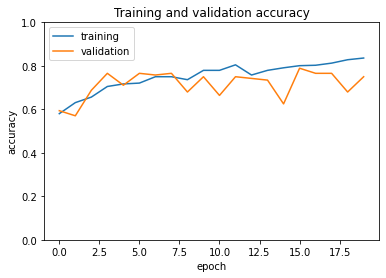

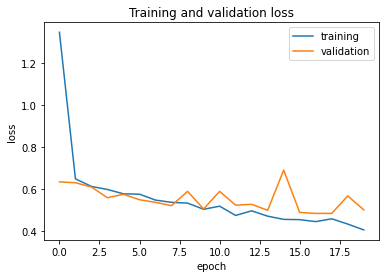

Found 160 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


{'male': 0, 'female': 1}
Overall Categorical Accuracy: 77.50%
Confusion Matrix
[[64 16]
 [20 60]]
AUC: 0.775


Precision  Recall   F-Score  Support  Specificity
male     0.761905    0.80  0.780488     80.0     0.789474
female   0.789474    0.75  0.769231     80.0     0.800000

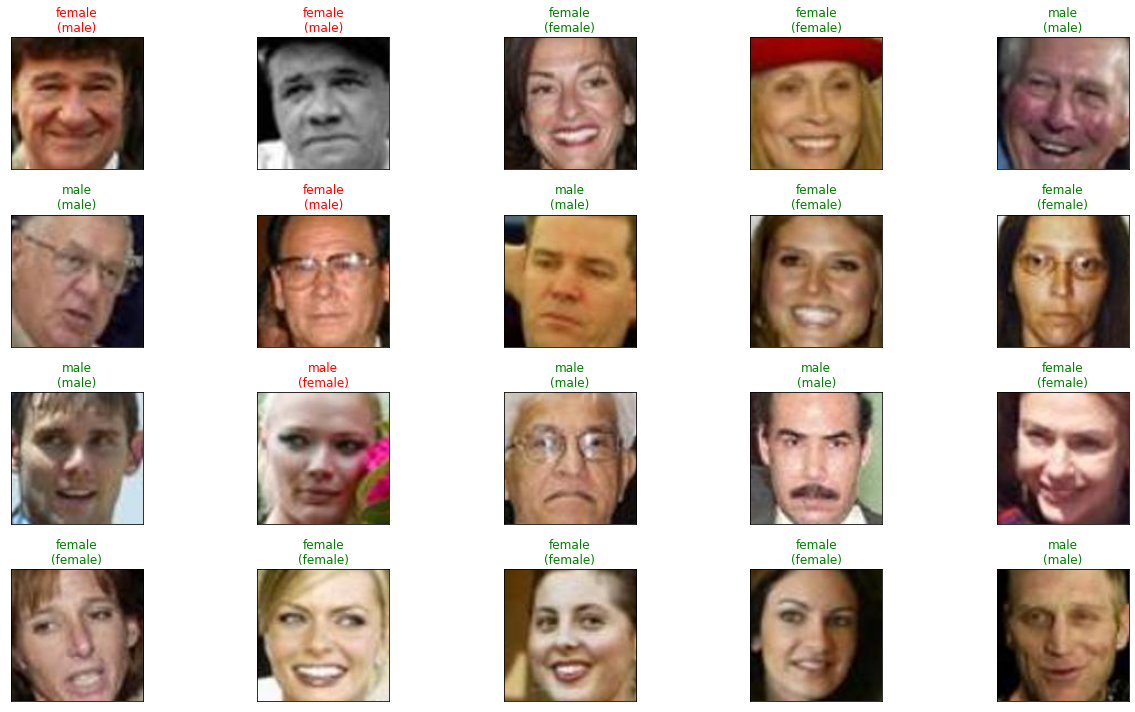

In [ ]:
batch_size = 32
height, width = (120,120)
train_dataset = imgdatagen.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('male','female'),
    batch_size = batch_size,
    subset = 'training'
)

val_dataset = imgdatagen.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('male','female'),
    batch_size = batch_size,
    subset = 'validation'
)

#Feed Forward Fully Connected Neural Network

model = keras.models.Sequential()

model.add(keras.layers.Dense(50, input_shape=(height,width,3), activation='relu'))
model.add(keras.layers.Dense(24, activation='relu'))
model.add( keras.layers.Flatten() )
model.add( keras.layers.Dropout(0.9) )

model.add( keras.layers.Dense(
    2, activation='softmax',
    )
)

model.summary()

#Optimizer
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adagrad(lr = 0.01),
              metrics=['acc'])
#Model Training
# Saves Keras model after each epoch
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='/content/gender_classification_dataset/img_model_adagrad.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)
history = model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=20,
    callbacks= checkpointer
)


plot_history(history,(0,1))

#Testing our model
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory('/content/gender_classification_dataset/test',
                                             target_size = (height, width), 
                                             batch_size = 1,
                                             class_mode= None,
                                             classes=classes, 
                                             shuffle=False,
                                             seed=42)
model.load_weights('/content/gender_classification_dataset/img_model_adagrad.weights.best.hdf5')

predicted_classes = model.predict_classes(testgen)

class_indices = train_dataset.class_indices
print(class_indices)
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

#Plot to visualize a sample of test dataset images        
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

#Accuracy, Precision, Recall/sensitivity, F-score, Support, Specificity, Confusion Matrix, AUC
display_results(true_classes, predicted_classes, class_indices.values())


In [ ]:
optimizer_list.append('Adagrad')

In [ ]:

# Probability of test dataset belonging to {male , female}

# female is labeled as 1

# {'male': 0, 'female': 1}

import numpy as np
np.set_printoptions(suppress=True)
prob_male_female = model.predict_proba(testgen, batch_size=1, verbose=1)
print(prob_male_female)

# Probability of each test dataset image falling into positive class

# female is labeled as 1

# {'male': 0, 'female': 1}

# image path---------> prob(image belongs to female dataset)

print("%-70s %-10s" % ("Image_Path", "Probability( Female)"))
for i in range(len(testgen.filepaths)):
  print("%-70s %-10.4f" % (testgen.filepaths[i], prob_male_female[i][1]))

 25/160 [===>..........................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


160/160 [==============================] - 0s 3ms/step
[[0.99557036 0.0044296 ]
 [0.58984435 0.41015562]
 [0.8265067  0.17349337]
 [0.99169195 0.00830803]
 [0.96611226 0.03388776]
 [0.67123926 0.3287607 ]
 [0.97686815 0.02313191]
 [0.98530096 0.01469903]
 [0.98932415 0.01067591]
 [0.74896926 0.25103068]
 [0.03407178 0.96592826]
 [0.08974306 0.910257  ]
 [0.9930735  0.00692654]
 [0.83511645 0.1648835 ]
 [0.6166507  0.38334924]
 [0.78174233 0.2182577 ]
 [0.9159902  0.08400983]
 [0.9992409  0.00075914]
 [0.89872354 0.10127648]
 [0.9709917  0.02900829]
 [0.9511906  0.04880936]
 [0.36369774 0.63630223]
 [0.99049556 0.0095044 ]
 [0.70517915 0.29482085]
 [0.6608841  0.3391159 ]
 [0.6211795  0.37882054]
 [0.30463424 0.6953658 ]
 [0.97190607 0.02809393]
 [0.86940104 0.13059898]
 [0.92715055 0.07284943]
 [0.0640266  0.93597335]
 [0.996942   0.00305794]
 [0.8861493  0.11385078]
 [0.9896365  0.01036357]
 [0.9896882  0.01031177]
 [0.7668683  0.23313169]
 [0.52964735 0.47035262]
 [0.9148512  0.08514

Adadelta

Found 512 images belonging to 2 classes.
Found 128 images belonging to 2 classes.
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 120, 120, 50)      200       
_________________________________________________________________
dense_19 (Dense)             (None, 120, 120, 24)      1224      
_________________________________________________________________
flatten_6 (Flatten)          (None, 345600)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 345600)            0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 691202    
Total params: 692,626
Trainable params: 692,626
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


16/16 [==============================] - 2s 68ms/step - loss: 0.7085 - acc: 0.4963 - val_loss: 0.6851 - val_acc: 0.6641

Epoch 00001: val_loss improved from inf to 0.68508, saving model to /content/gender_classification_dataset/img_model_adadetla.weights.best.hdf5
Epoch 2/20
16/16 [==============================] - 1s 56ms/step - loss: 0.7161 - acc: 0.4449 - val_loss: 0.6807 - val_acc: 0.6953

Epoch 00002: val_loss improved from 0.68508 to 0.68071, saving model to /content/gender_classification_dataset/img_model_adadetla.weights.best.hdf5
Epoch 3/20
16/16 [==============================] - 1s 57ms/step - loss: 0.6843 - acc: 0.5820 - val_loss: 0.6760 - val_acc: 0.6406

Epoch 00003: val_loss improved from 0.68071 to 0.67603, saving model to /content/gender_classification_dataset/img_model_adadetla.weights.best.hdf5
Epoch 4/20
16/16 [==============================] - 1s 50ms/step - loss: 0.6960 - acc: 0.5307 - val_loss: 0.6722 - val_acc: 0.6875

Epoch 00004: val_loss improved from 0.67603

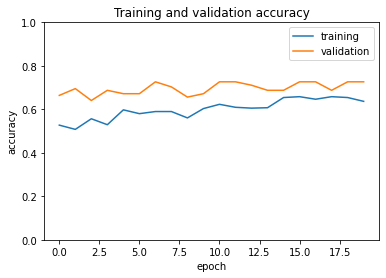

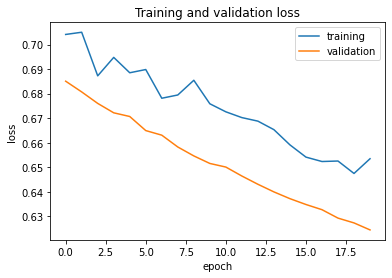

Found 160 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


{'male': 0, 'female': 1}
Overall Categorical Accuracy: 64.38%
Confusion Matrix
[[56 24]
 [33 47]]
AUC: 0.644


Precision  Recall   F-Score  Support  Specificity
male     0.629213  0.7000  0.662722     80.0     0.661972
female   0.661972  0.5875  0.622517     80.0     0.700000

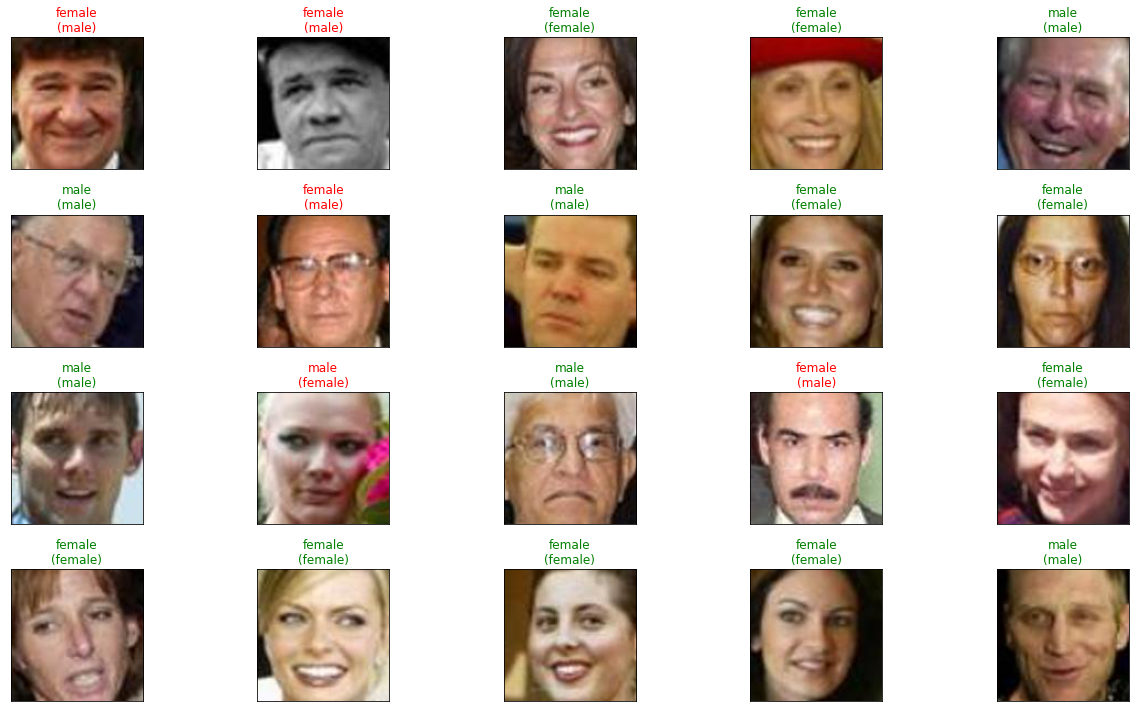

In [ ]:
batch_size = 32
height, width = (120,120)
train_dataset = imgdatagen.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('male','female'),
    batch_size = batch_size,
    subset = 'training'
)

val_dataset = imgdatagen.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('male','female'),
    batch_size = batch_size,
    subset = 'validation'
)

#Feed Forward Fully Connected Neural Network

model = keras.models.Sequential()

model.add(keras.layers.Dense(50, input_shape=(height,width,3), activation='relu'))
model.add(keras.layers.Dense(24, activation='relu'))
model.add( keras.layers.Flatten() )
model.add( keras.layers.Dropout(0.9) )

model.add( keras.layers.Dense(
    2, activation='softmax',
    )
)

model.summary()

#Optimizer
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adadelta(lr = 0.01),
              metrics=['acc'])
#Model Training
# Saves Keras model after each epoch
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='/content/gender_classification_dataset/img_model_adadetla.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)
history = model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=20,
    callbacks= checkpointer
)


plot_history(history,(0,1))

#Testing our model
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory('/content/gender_classification_dataset/test',
                                             target_size = (height, width), 
                                             batch_size = 1,
                                             class_mode= None,
                                             classes=classes, 
                                             shuffle=False,
                                             seed=42)
model.load_weights('/content/gender_classification_dataset/img_model_adadetla.weights.best.hdf5')

predicted_classes = model.predict_classes(testgen)

class_indices = train_dataset.class_indices
print(class_indices)
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

#Plot to visualize a sample of test dataset images        
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

#Accuracy, Precision, Recall/sensitivity, F-score, Support, Specificity, Confusion Matrix, AUC
display_results(true_classes, predicted_classes, class_indices.values())


In [ ]:
optimizer_list.append('Adadelta(lr=0.01)')

In [ ]:

# Probability of test dataset belonging to {male , female}

# female is labeled as 1

# {'male': 0, 'female': 1}

import numpy as np
np.set_printoptions(suppress=True)
prob_male_female = model.predict_proba(testgen, batch_size=1, verbose=1)
print(prob_male_female)

# Probability of each test dataset image falling into positive class

# female is labeled as 1

# {'male': 0, 'female': 1}

# image path---------> prob(image belongs to female dataset)

print("%-70s %-10s" % ("Image_Path", "Probability( Female)"))
for i in range(len(testgen.filepaths)):
  print("%-70s %-10.4f" % (testgen.filepaths[i], prob_male_female[i][1]))

 28/160 [====>.........................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


160/160 [==============================] - 0s 3ms/step
[[0.7461177  0.25388232]
 [0.55354834 0.44645163]
 [0.6370557  0.36294428]
 [0.6852014  0.3147986 ]
 [0.67169905 0.32830095]
 [0.47932371 0.5206763 ]
 [0.60350347 0.3964965 ]
 [0.7789343  0.2210657 ]
 [0.6647473  0.33525276]
 [0.70828694 0.29171303]
 [0.23270042 0.7672996 ]
 [0.3550916  0.6449084 ]
 [0.6249994  0.37500057]
 [0.68095464 0.3190454 ]
 [0.43916494 0.56083506]
 [0.58317345 0.4168266 ]
 [0.56190085 0.43809918]
 [0.80886596 0.19113404]
 [0.60721385 0.39278615]
 [0.6163323  0.3836677 ]
 [0.6345487  0.36545128]
 [0.45645475 0.54354525]
 [0.7309303  0.26906964]
 [0.40872052 0.5912795 ]
 [0.5127188  0.48728114]
 [0.4175993  0.5824007 ]
 [0.5336251  0.46637487]
 [0.6960719  0.30392808]
 [0.65553737 0.34446263]
 [0.59857476 0.40142524]
 [0.2860913  0.71390873]
 [0.6008992  0.39910084]
 [0.5504145  0.4495855 ]
 [0.7345357  0.26546428]
 [0.6652392  0.33476081]
 [0.4585931  0.54140687]
 [0.4661317  0.5338683 ]
 [0.524647   0.47535

Adadelta

Found 512 images belonging to 2 classes.
Found 128 images belonging to 2 classes.
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 120, 120, 50)      200       
_________________________________________________________________
dense_22 (Dense)             (None, 120, 120, 24)      1224      
_________________________________________________________________
flatten_7 (Flatten)          (None, 345600)            0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 345600)            0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 691202    
Total params: 692,626
Trainable params: 692,626
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


16/16 [==============================] - 2s 66ms/step - loss: 1.3467 - acc: 0.5237 - val_loss: 0.6223 - val_acc: 0.6797

Epoch 00001: val_loss improved from inf to 0.62235, saving model to /content/gender_classification_dataset/img_model_adadetla2.weights.best.hdf5
Epoch 2/20
16/16 [==============================] - 1s 52ms/step - loss: 0.6411 - acc: 0.6427 - val_loss: 0.5856 - val_acc: 0.7422

Epoch 00002: val_loss improved from 0.62235 to 0.58558, saving model to /content/gender_classification_dataset/img_model_adadetla2.weights.best.hdf5
Epoch 3/20
16/16 [==============================] - 1s 54ms/step - loss: 0.6077 - acc: 0.7039 - val_loss: 0.5693 - val_acc: 0.7656

Epoch 00003: val_loss improved from 0.58558 to 0.56931, saving model to /content/gender_classification_dataset/img_model_adadetla2.weights.best.hdf5
Epoch 4/20
16/16 [==============================] - 1s 55ms/step - loss: 0.5703 - acc: 0.7093 - val_loss: 0.5636 - val_acc: 0.7656

Epoch 00004: val_loss improved from 0.56

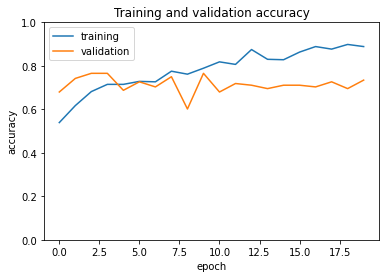

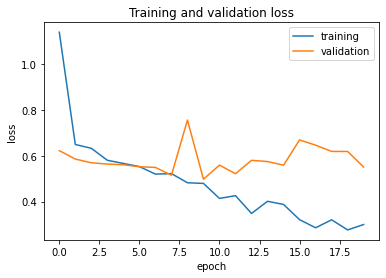

Found 160 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


{'male': 0, 'female': 1}
Overall Categorical Accuracy: 70.00%
Confusion Matrix
[[50 30]
 [18 62]]
AUC: 0.700


Precision  Recall   F-Score  Support  Specificity
female   0.673913   0.775  0.720930     80.0     0.625000
male     0.735294   0.625  0.675676     80.0     0.673913

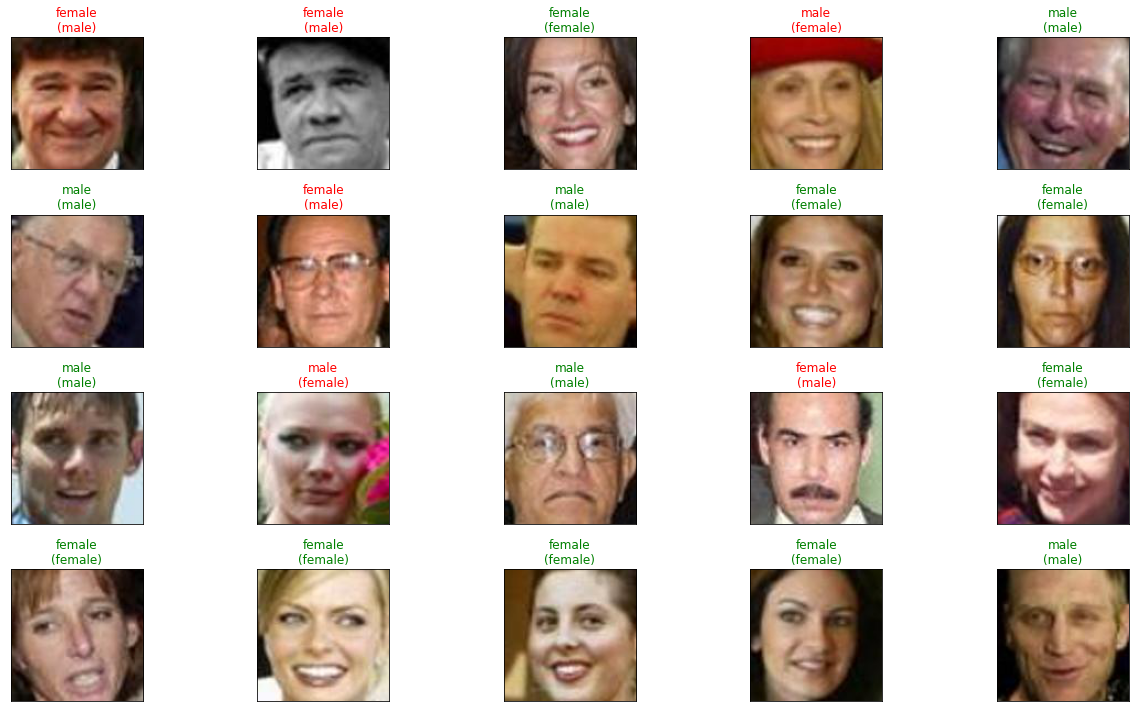

In [ ]:
batch_size = 32
height, width = (120,120)
train_dataset = imgdatagen.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('male','female'),
    batch_size = batch_size,
    subset = 'training'
)

val_dataset = imgdatagen.flow_from_directory(
    os.getcwd(),
    target_size = (height, width), 
    classes = ('male','female'),
    batch_size = batch_size,
    subset = 'validation'
)

#Feed Forward Fully Connected Neural Network

model = keras.models.Sequential()

model.add(keras.layers.Dense(50, input_shape=(height,width,3), activation='relu'))
model.add(keras.layers.Dense(24, activation='relu'))
model.add( keras.layers.Flatten() )
model.add( keras.layers.Dropout(0.9) )

model.add( keras.layers.Dense(
    2, activation='softmax',
    )
)

model.summary()

#Optimizer
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adadelta(lr = 1),
              metrics=['acc'])
#Model Training
# Saves Keras model after each epoch
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='/content/gender_classification_dataset/img_model_adadetla2.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)
history = model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=20,
    callbacks= checkpointer
)


plot_history(history,(0,1))

#Testing our model
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory('/content/gender_classification_dataset/test',
                                             target_size = (height, width), 
                                             batch_size = 1,
                                             class_mode= None,
                                             classes=classes, 
                                             shuffle=False,
                                             seed=42)
model.load_weights('/content/gender_classification_dataset/img_model_adadetla2.weights.best.hdf5')

predicted_classes = model.predict_classes(testgen)

class_indices = train_dataset.class_indices
print(class_indices)
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

#Plot to visualize a sample of test dataset images        
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

#Accuracy, Precision, Recall/sensitivity, F-score, Support, Specificity, Confusion Matrix, AUC
display_results(true_classes, predicted_classes, class_indices.values())


In [ ]:
optimizer_list.append('Adadelta(lr=1)')

In [ ]:

# Probability of test dataset belonging to {male , female}

# female is labeled as 1

# {'male': 0, 'female': 1}

import numpy as np
np.set_printoptions(suppress=True)
prob_male_female = model.predict_proba(testgen, batch_size=1, verbose=1)
print(prob_male_female)

# Probability of each test dataset image falling into positive class

# female is labeled as 1

# {'male': 0, 'female': 1}

# image path---------> prob(image belongs to female dataset)

print("%-70s %-10s" % ("Image_Path", "Probability( Female)"))
for i in range(len(testgen.filepaths)):
  print("%-70s %-10.4f" % (testgen.filepaths[i], prob_male_female[i][1]))

 30/160 [====>.........................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


160/160 [==============================] - 0s 3ms/step
[[0.99233776 0.00766228]
 [0.19871067 0.8012893 ]
 [0.4040767  0.59592324]
 [0.97461504 0.02538496]
 [0.8950216  0.10497841]
 [0.5117074  0.48829257]
 [0.9040815  0.09591851]
 [0.900394   0.09960599]
 [0.98915124 0.01084869]
 [0.15700434 0.8429957 ]
 [0.07986058 0.9201395 ]
 [0.182859   0.81714106]
 [0.9937459  0.00625411]
 [0.9152853  0.08471467]
 [0.4099436  0.5900564 ]
 [0.7977574  0.20224264]
 [0.7825592  0.21744083]
 [0.99951386 0.00048613]
 [0.8655995  0.13440053]
 [0.8970056  0.10299438]
 [0.9130877  0.08691228]
 [0.11122862 0.88877136]
 [0.97863746 0.02136258]
 [0.2512001  0.7487999 ]
 [0.64289975 0.35710025]
 [0.16449703 0.835503  ]
 [0.16771233 0.8322877 ]
 [0.95378006 0.04621998]
 [0.8786292  0.12137077]
 [0.80271155 0.1972884 ]
 [0.06264969 0.9373503 ]
 [0.99307305 0.00692692]
 [0.7332274  0.26677266]
 [0.9776285  0.02237144]
 [0.9665518  0.03344819]
 [0.4339217  0.5660783 ]
 [0.35902208 0.640978  ]
 [0.59555715 0.40444

Plotting accuracy of all optimizers

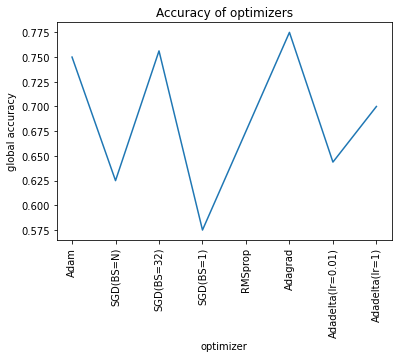

In [ ]:
plt.plot(optimizer_list, accuracy_list)
plt.xlabel('optimizer')
plt.ylabel('global accuracy')
plt.title('Accuracy of optimizers')
plt.xticks(rotation = 90)
plt.show()